In [9]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [10]:
#from google.colab import files
#uploaded = files.upload()

In [11]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [12]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [13]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()

In [14]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [15]:
def with_news_LSTM(company, df):
  len_df = df.shape[0]
  # Data Preprocessing
  # splitting training and testing data
  cols = ['adj_close','mean_compound']
  cols2 = ['date']
  split = 0.85
  i_split = int(len(df) * split)
  data_train = df.get(cols).values[:i_split]
  data_test  = df.get(cols).values[i_split:]
  data_test2  = df.get(cols2).values[i_split:]

  len_train  = len(data_train)
  len_test   = len(data_test)
  len_train_windows = None
  # Creating Windows for Test Data
  sequence_length=10
  data_windows_test = create_windows(data_test,len(data_test),sequence_length)
  # get original y_test
  y_test_original = data_windows_test[:, -1, [0]]
  print('y_test_original.shape',y_test_original.shape)

  # Normalization of Test Data
  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  # Train Data preparation
  data_windows = create_windows(data_train,len(data_train),sequence_length)
  normalized_data_train,rmax_train, rmin_train = Normalize_data(data_windows)

  x_train = normalized_data_train[:, :-1]
  y_train = normalized_data_train[:, -1,[0]]

  # LSTM Model
  # Setting the parameter  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
 
  # LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=30, batch_size=32)

  plot_training_loss(hist)

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)

  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)
 
  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")

  

  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [16]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [17]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
y_test_original.shape (251, 1)
Epoch 1/30
46/46 [==============================] - 6s 30ms/step - loss: 0.3046 - mean_squared_error: 0.3046
Epoch 2/30
46/46 [==============================] - 1s 29ms/step - loss: 0.1219 - mean_squared_error: 0.1219
Epoch 3/30
46/46 [==============================] - 1s 28ms/step - loss: 0.0871 - mean_squared_error: 0.0871
Epoch 4/30
46/46 [==============================] - 1s 28ms/step - loss: 0.0850 - mean_squared_error: 0.0850
Epoch 5/30
46/46 [==============================] - 1s 28ms/step - loss: 0.0805 - mean_squared_error: 0.0805
Epoch 6/30
46/46 [==============================] - 1s 27ms/step - loss: 0.0839 - mean_squared_error: 0.0839
Epoch 7/30
46/46 [==============================] - 1s 28ms/step - loss: 0.0817 - mean_squared_error: 0.0817
Epoch 8/30
46/46 [==============================] - 1s 27ms/step - loss: 0.0847 - mean_squared_error: 0.0847
Epoch 9/30
46/46 [==============================] - 1s 28ms/s

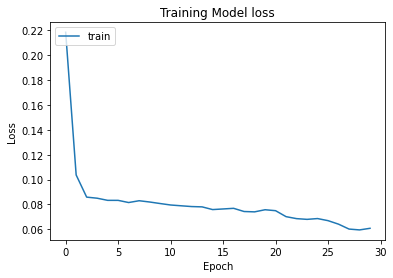

           date     Actual  Predicted
0    2019-01-30  37.715031  38.045750
1    2019-01-31  40.292267  40.199957
2    2019-02-01  40.582428  40.481173
3    2019-02-04  40.601936  40.360683
4    2019-02-05  41.755226  41.423532
..          ...        ...        ...
246  2020-01-22  78.347801  77.464123
247  2020-01-23  78.627464  77.777986
248  2020-01-24  79.006119  78.437903
249  2020-01-27  78.778435  78.418801
250  2020-01-28  76.461929  76.522450

[251 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

8/8 - 1s - loss: 0.0489 - mean_squared_error: 0.0489
LSTM Model Loss =  [0.048870280385017395, 0.048870280385017395]
Model Accuracy =  99.11344754755628
Mean Absolute Error =  0.4709985662198892  degrees
Mean Squared Error =  0.35394940877004366
Root Mean Squared Error =  0.5949364745668597

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
y_test_original.shape (197, 1)
Epoch 1

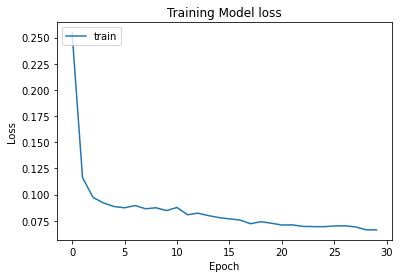

           date       Actual    Predicted
0    2019-04-12  1844.069946  1830.284769
1    2019-04-15  1843.060059  1846.439570
2    2019-04-17  1844.869995  1842.969387
3    2019-04-22  1864.819946  1858.484429
4    2019-04-23  1887.310059  1879.938619
..          ...          ...          ...
192  2020-01-30  1858.000000  1846.983220
193  2020-01-31  1870.680054  1856.155895
194  2020-02-03  2008.719971  1955.433713
195  2020-02-04  2004.199951  1961.910828
196  2020-02-05  2049.669922  2012.847949

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0574 - mean_squared_error: 0.0574
LSTM Model Loss =  [0.057397715747356415, 0.057397715747356415]
Model Accuracy =  99.1651426892565
Mean Absolute Error =  15.353431883003967  degrees
Mean Squared Error =  427.47633992128715
Root Mean Squared Error =  20.675500959379125

--------------------------------------------------------------------------

Evaluating Model for Company

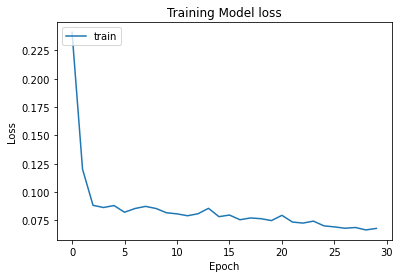

           date     Actual  Predicted
0    2019-04-12  40.507534  40.275842
1    2019-04-15  40.591747  40.469264
2    2019-04-17  40.554325  40.436947
3    2019-04-22  40.273605  40.316806
4    2019-04-23  39.918026  40.100933
..          ...        ...        ...
192  2020-01-30  41.956577  42.209425
193  2020-01-31  43.992935  42.678217
194  2020-02-03  42.993965  43.014707
195  2020-02-04  43.186077  43.309182
196  2020-02-05  43.579899  43.505742

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0446 - mean_squared_error: 0.0446
LSTM Model Loss =  [0.04462321475148201, 0.04462321475148201]
Model Accuracy =  99.3153673562496
Mean Absolute Error =  0.26866165137036524  degrees
Mean Squared Error =  0.17184237652991474
Root Mean Squared Error =  0.4145387515418972

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
y_test_original.shape (197, 1)
Epoch 1/3

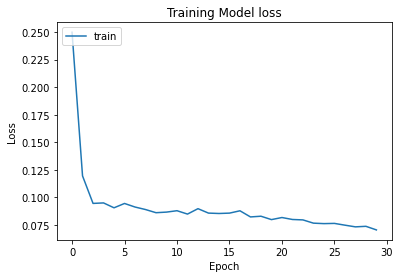

           date       Actual    Predicted
0    2019-04-12  1204.619995  1203.564805
1    2019-04-15  1217.869995  1216.300527
2    2019-04-17  1221.099976  1216.700173
3    2019-04-22  1236.339966  1234.841800
4    2019-04-23  1248.839966  1248.208108
..          ...          ...          ...
192  2020-01-30  1458.630005  1450.475026
193  2020-01-31  1455.839966  1449.983513
194  2020-02-03  1434.229980  1452.274622
195  2020-02-04  1485.939941  1455.486479
196  2020-02-05  1447.069946  1461.731641

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0848 - mean_squared_error: 0.0848
LSTM Model Loss =  [0.08478816598653793, 0.08478816598653793]
Model Accuracy =  99.01783701901097
Mean Absolute Error =  11.886060737436704  degrees
Mean Squared Error =  338.6407998218388
Root Mean Squared Error =  18.40219551634638

--------------------------------------------------------------------------

Evaluating Model for Company:  

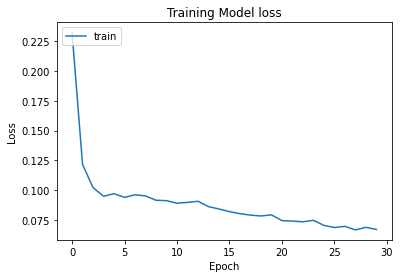

           date     Actual  Predicted
0    2019-04-12  35.292530  35.271110
1    2019-04-15  35.146770  35.200129
2    2019-04-17  35.205078  35.496705
3    2019-04-22  34.952431  35.345726
4    2019-04-23  35.127342  35.387052
..          ...        ...        ...
192  2020-01-30  33.982201  33.968851
193  2020-01-31  34.453903  34.046646
194  2020-02-03  32.979836  32.938597
195  2020-02-04  33.795483  33.084349
196  2020-02-05  36.763275  33.641553

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0872 - mean_squared_error: 0.0872
LSTM Model Loss =  [0.08717203885316849, 0.08717203885316849]
Model Accuracy =  99.05067788775857
Mean Absolute Error =  0.3521219942837519  degrees
Mean Squared Error =  0.2575586733774282
Root Mean Squared Error =  0.5075023875583525

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
y_test_original.shape (197, 1)
Epoch 1/30


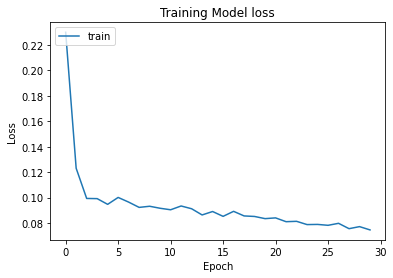

           date     Actual  Predicted
0    2019-04-12  72.001968  72.461720
1    2019-04-15  71.097000  72.251959
2    2019-04-17  70.859787  71.357623
3    2019-04-22  71.545097  71.550343
4    2019-04-23  72.836647  71.689060
..          ...        ...        ...
192  2020-01-30  58.377277  58.846827
193  2020-01-31  58.996475  59.346581
194  2020-02-03  56.565224  56.664126
195  2020-02-04  55.299515  55.350268
196  2020-02-05  54.607475  54.839467

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0706 - mean_squared_error: 0.0706
LSTM Model Loss =  [0.0705668106675148, 0.0705668106675148]
Model Accuracy =  99.1971825176462
Mean Absolute Error =  0.5190042145970178  degrees
Mean Squared Error =  0.4745917924385233
Root Mean Squared Error =  0.6889062290606199

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
y_test_original.shape (197, 1)
Epoch 1/30
37/

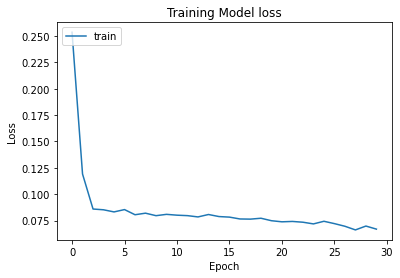

           date     Actual  Predicted
0    2019-04-12  76.076523  76.532385
1    2019-04-15  75.901398  76.027236
2    2019-04-17  75.405174  75.532935
3    2019-04-22  70.910042  70.973769
4    2019-04-23  72.495987  71.129205
..          ...        ...        ...
192  2020-01-30  87.775566  89.169915
193  2020-01-31  87.795273  89.417057
194  2020-02-03  85.806183  86.611835
195  2020-02-04  85.727409  86.259298
196  2020-02-05  86.879509  86.684784

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 1s - loss: 0.0893 - mean_squared_error: 0.0893
LSTM Model Loss =  [0.08925970643758774, 0.08925970643758774]
Model Accuracy =  99.04669299015809
Mean Absolute Error =  0.7728505675199853  degrees
Mean Squared Error =  0.9853212338129104
Root Mean Squared Error =  0.992633484128412

--------------------------------------------------------------------------



In [18]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "CS_stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = with_news_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)


In [19]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.470999,0.353949,99.113448,0.594936
1,AMZN,15.353432,427.476340,99.165143,20.675501
2,ADM,0.268662,0.171842,99.315367,0.414539
3,GOOG,11.886061,338.640800,99.017837,18.402196
4,EBAY,0.352122,0.257559,99.050678,0.507502
5,XOM,0.519004,0.474592,99.197183,0.688906
6,ABT,0.772851,0.985321,99.046693,0.992633


In [24]:
# Mean Accuracy for With news
mean_results = company_results.mean(axis = 0)
mean_results

MAE           4.231876
MSE         109.765772
Accuracy     99.129478
RMSE          6.039459
dtype: float64

In [26]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P5_LSTM_company_specific_with_news"+current_time+".csv"
company_results.to_csv(name)